# SQL Queries for Business Analysis
## by [Dan Hillman](http://danhillman.dev)
### 1. What is the purpose of this project?
The purpose of this project is to practice SQL queries and joins to other external data sources. This project will be updated periodically with new content.
### 2. What data/database is used in this project?
SQLite3 is used to query [chinook.db](http://www.sqlitetutorial.net/sqlite-sample-database/), a demo database for SQLite.
### 3. Where did these exercises originate?
Some of the exercises are adapted from a project within Dataquest's SQL curriculum. The CSV join to SQL Query section was created independently.

## Import Libraries and Initialize Setup

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

To ensure the `pd.read()` method won't have to be written every time a query is run, it was advised to create a `run_query` function. 

In [3]:
run_query("SELECT country FROM customers").head()

,Country
0,Brazil
1,Germany
2,Canada
3,Norway
4,Czech Republic


The `run_query()` function works correctly.

## Exercises
The exercises below are comprised of adapted questions from Dataquest's SQL curriculum and original questions.

### Tracks Sold and % of Total Tracks Sold by Genre

In [4]:
q = """

SELECT
    g.Name AS genre
  , COUNT(ii.TrackID) AS tracks_sold
  , CAST(COUNT(ii.TrackID) AS FLOAT) / CAST(
      (
        SELECT
           COUNT(*) AS tracks_count
           FROM invoice_items AS ii
           LEFT JOIN invoices AS i
           ON i.InvoiceID = ii.InvoiceID
           LEFT JOIN customers AS c
           ON c.CustomerID = i.CustomerID
           WHERE c.Country = 'USA'
       ) 
       AS FLOAT) AS pct_sold
FROM invoice_items AS ii
LEFT JOIN tracks AS t
ON t.TrackID = ii.TrackID
LEFT JOIN genres AS g
ON g.GenreID = t.GenreID
LEFT JOIN invoices AS i
ON i.InvoiceID = ii.InvoiceID
LEFT JOIN customers AS c
ON c.CustomerID = i.CustomerID
WHERE c.Country = 'USA'
GROUP BY 1
ORDER BY 2 DESC;

"""

genre_tracks_sold =  run_query(q)
genre_tracks_sold.set_index("genre",drop=True,inplace=True)
genre_tracks_sold.head(10)

,tracks_sold,pct_sold
genre,,
Rock,157,0.317814
Latin,91,0.184211
Metal,64,0.129555
Alternative & Punk,50,0.101215
Jazz,22,0.044534
Blues,15,0.030364
TV Shows,14,0.028340
R&B/Soul,12,0.024291
Classical,8,0.016194


The "pct_sold" selection is calculated with the assumption of a "GROUP BY" clause effective in the numerator of the calculation. The subquery the `CAST(COUNT(ii.TrackID) AS FLOAT)` is divided by returns a count of all tracks sold in the USA.

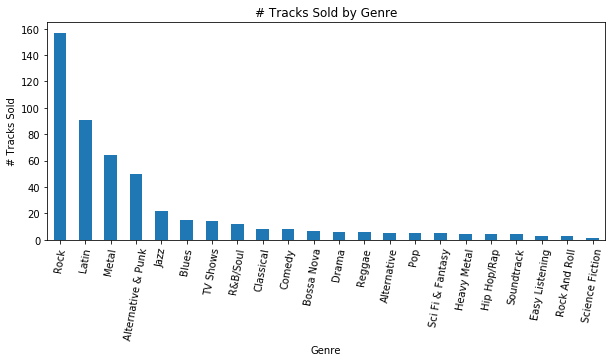

In [5]:
ax = genre_tracks_sold.plot(kind="bar", y="tracks_sold",figsize=(10,4),rot=80,legend=False)
ax.set_title("# Tracks Sold by Genre")
ax.set_xlabel("Genre")
ax.set_ylabel("# Tracks Sold")
plt.show()

"Rock" is the most sold genre in the Chinook database by far.

### $ Sales by Employee

In [6]:
q = """

SELECT
    e.FirstName || ' ' || e.LastName AS employee_name
  , SUM(UnitPrice) AS total_sales
FROM invoice_items AS ii
LEFT JOIN invoices AS i
ON i.InvoiceID = ii.InvoiceID
LEFT JOIN customers AS c
ON c.CustomerID = i.CustomerID
LEFT JOIN employees AS e
ON e.EmployeeID = c.SupportRepID
WHERE e.Title = 'Sales Support Agent'
GROUP BY 1
ORDER BY 2 DESC;
       
"""
em_sales = run_query(q)
em_sales.set_index("employee_name",drop=True,inplace=True)

Not a difficult query to pull off. The most important aspect of this query is understanding the aggregate function must be paired with a "GROUP BY" statement to group by "employee_name".

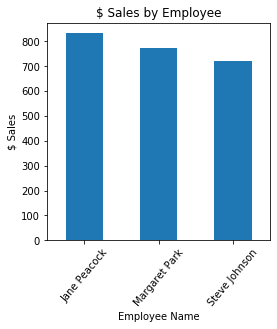

In [7]:
ax = em_sales.plot(kind="bar", y="total_sales",figsize=(4,4),rot=50,legend=False)
ax.set_title("$ Sales by Employee")
ax.set_xlabel("Employee Name")
ax.set_ylabel("$ Sales")
plt.show()

### Sales and Customer Metrics by Country
The subqueries below are combined into a main subquery to return a table of relevant sales and customer metrics grouped by country.

#### `tcs` Subquery
The `tcs` subquery is used to return a table of total sales for each customer ID.
#### `iamt` Subquery
The `iamt` subquery is used to return a table of the total sale amount of each invoice ID. Customer ID for each Invoice ID is included as well for joining purposes later.
#### `iavg` Subquery
The `iavg` subquery is used to return a table of the average order amount (total invoice sale amount) for each customer ID. The `iavg` calculates the average order amount by querying from the `iamt` subquery.
#### Main Query
The main query joins the above subqueries together and calculates a new field, "avg_sales_customer", and ultimately groups the selection by country. 

In [8]:
q ="""

WITH
tcs AS 
  (
    SELECT 
      c.CustomerID AS customer_id
      , SUM(ii.UnitPrice) AS total_sales
    FROM invoice_items AS ii
    LEFT JOIN Invoices AS i
    ON i.InvoiceID = ii.InvoiceID
    LEFT JOIN Customers AS c
    ON c.CustomerID = i.CustomerID
    GROUP BY 1
  ),
    
iamt AS 
  (
    SELECT 
      i.InvoiceID AS invoice_id
      , i.CustomerID AS customer_id
      , SUM(ii.UnitPrice) AS order_amount
    FROM invoice_items as ii
    LEFT JOIN invoices AS i
    ON ii.InvoiceID = i.InvoiceID
    GROUP BY 1
  ),
    
iavg AS 
  (
    SELECT
        iamt.customer_id
      , AVG(iamt.order_amount) AS avg_inv_amt
    FROM iamt
    GROUP BY 1
  )
  
SELECT
  c.Country AS country
  , COUNT(c.customerID) AS customer_count
  , SUM(tcs.total_sales) AS total_sales
  , ROUND(SUM(tcs.total_sales)/CAST(COUNT(c.customerID) AS FLOAT),2) AS avg_sales_customer
  , ROUND(AVG(iavg.avg_inv_amt),2) AS avg_order_amt
FROM customers AS c
LEFT JOIN tcs
ON tcs.customer_id = c.CustomerID
LEFT JOIN iavg
ON iavg.customer_id = c.CustomerID
GROUP BY 1
ORDER BY 3 DESC;

"""
country_stats = run_query(q)
country_stats.set_index("country",drop=True,inplace=True)
country_stats.head(10)

,customer_count,total_sales,avg_sales_customer,avg_order_amt
country,,,,
USA,13,523.06,40.24,5.75
Canada,8,303.96,38.00,5.43
France,5,195.10,39.02,5.57
Brazil,5,190.10,38.02,5.43
Germany,4,156.48,39.12,5.59
United Kingdom,3,112.86,37.62,5.37
Czech Republic,2,90.24,45.12,6.45
Portugal,2,77.24,38.62,5.52
India,2,75.26,37.63,5.81


In [9]:
country_stats_cc = country_stats.loc[:,"customer_count"].head(9)
country_stats_ts = country_stats.loc[:,"total_sales"].head(9)
country_stats_asc = country_stats.loc[:,"avg_sales_customer"].head(9)
country_stats_aoa = country_stats.loc[:,"avg_order_amt"].head(9)

The dimensions of `country_stats` are broken out into specific DataFrames that will be visualized below.

### Visualizations of Sales and Customer Metrics by Country

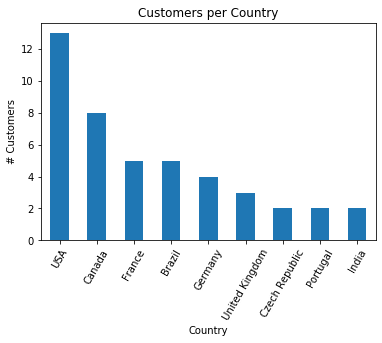

In [10]:
ax = country_stats_cc.plot(kind="bar", rot=60)
ax.set_title("Customers per Country")
ax.set_xlabel("Country")
ax.set_ylabel("# Customers")
plt.show()

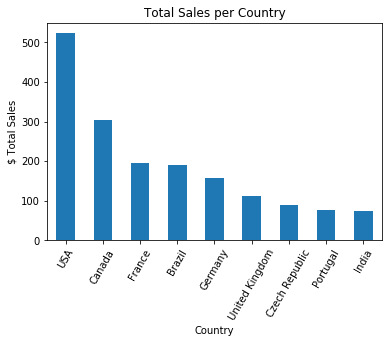

In [11]:
ax = country_stats_ts.plot(kind="bar",rot=60)
ax.set_title("Total Sales per Country")
ax.set_xlabel("Country")
ax.set_ylabel("$ Total Sales")
plt.show()

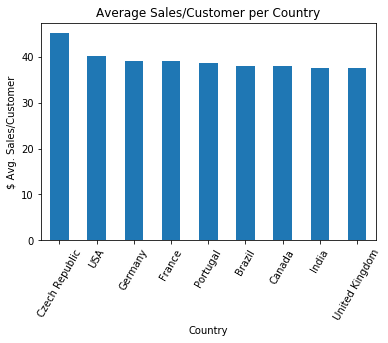

In [12]:
ax = country_stats_asc.sort_values(ascending=False).plot(kind="bar",rot=60)
ax.set_title("Average Sales/Customer per Country")
ax.set_xlabel("Country")
ax.set_ylabel("$ Avg. Sales/Customer")
plt.show()

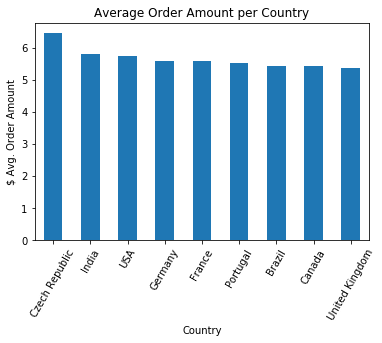

In [13]:
ax = country_stats_aoa.sort_values(ascending=False).plot(kind="bar",rot=60)
ax.set_title("Average Order Amount per Country")
ax.set_xlabel("Country")
ax.set_ylabel("$ Avg. Order Amount")
plt.show()

## Merging a CSV with a SQL Query
A common operation when using SQL is knitting together the data from a SQL Query and the data from a CSV. Below is an elegant technique to combine a SQL query and CSV.

### "Why Classic Rock Isn't What It Used to Be" Dataset from FiveThirtyEight
The CSV data came from FiveThirtyEight's article on ["Why Classic Rock Isn't What It Used to Be"](https://fivethirtyeight.com/features/why-classic-rock-isnt-what-it-used-to-be/). The author of the article tracked how many times a track was played on each classic rock station in 30 major metropolitan areas of the US in June 2014. The data can be downloaded [here](https://data.world/fivethirtyeight/classic-rock).
#### What is the goal with this data?
The goal of using this data is to analyze how many times per month the classic rock artists in the Chinook database are played on the radio in major metropolitan areas in the US. The track play count per artist from the CSV will be merged with the artist table from the Chinook database. The CSV and SQL query will be joined on an "inner join" to ensure only the artists both have in common will be contained in the final "merged" DataFrame.

In [14]:
cr_song_list = pd.read_csv("fivethirtyeight-classic-rock/classic-rock-song-list.csv")
cr_song_list.head()

,Song Clean,ARTIST CLEAN,Release Year,COMBINED,First?,Year?,PlayCount,F*G
0,Caught Up in You,.38 Special,1982,Caught Up in You by .38 Special,1,1,82,82
1,Fantasy Girl,.38 Special,NaN,Fantasy Girl by .38 Special,1,0,3,0
2,Hold On Loosely,.38 Special,1981,Hold On Loosely by .38 Special,1,1,85,85
3,Rockin' Into the Night,.38 Special,1980,Rockin' Into the Night by .38 Special,1,1,18,18
4,Art For Arts Sake,10cc,1975,Art For Arts Sake by 10cc,1,1,1,1


The most relevant columns to be merged will be the "ARTIST CLEAN" and "PlayCount" columns.

In [15]:
cr_artist_list = cr_song_list.loc[:,["ARTIST CLEAN","PlayCount"]]
cr_artist_list_group = cr_artist_list.groupby(by=["ARTIST CLEAN"], as_index=False).sum()
cr_artist_list_group.head()

,ARTIST CLEAN,PlayCount
0,.38 Special,188
1,10cc,1
2,3 Doors Down,20
3,4 Non Blondes,3
4,AC/DC,866


The `cr_artist_list` DataFrame has been grouped by "ARTIST CLEAN" and aggregated by the sum of "PlayCount" into `cr_artist_list_group`.

In [16]:
cr_artist_list_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475 entries, 0 to 474
Data columns (total 2 columns):
ARTIST CLEAN    475 non-null object
PlayCount       475 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.1+ KB


`cr_artist_list_group` contains data on 475 different artists.

### Artist Name SQL Query from Chinook Database

In [17]:
q = """
SELECT
  Name AS artist_name
FROM artists
GROUP BY 1;
"""
artist_names_ch = run_query(q)
artist_names_ch.head()

,artist_name
0,A Cor Do Som
1,AC/DC
2,Aaron Copland & London Symphony Orchestra
3,Aaron Goldberg
4,Academy of St. Martin in the Fields & Sir Nevi...


The query above selects all artists from the "artists" table from the Chinook database and assigns the query to the `artist_names_ch` DataFrame. A "GROUP BY" clause was included to ensure any duplicates will not be present. 

In [18]:
artist_names_ch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 1 columns):
artist_name    275 non-null object
dtypes: object(1)
memory usage: 2.2+ KB


`artist_names_ch` contains 275 artists.

In [19]:
merged_artists = artist_names_ch.merge(cr_artist_list_group,
                                    how="inner",
                                    left_on="artist_name",
                                    right_on="ARTIST CLEAN")
merged_artists.head(10)

,artist_name,ARTIST CLEAN,PlayCount
0,AC/DC,AC/DC,866
1,Aerosmith,Aerosmith,813
2,Alanis Morissette,Alanis Morissette,7
3,Alice In Chains,Alice In Chains,22
4,Audioslave,Audioslave,1
5,Black Sabbath,Black Sabbath,229
6,Creedence Clearwater Revival,Creedence Clearwater Revival,332
7,Deep Purple,Deep Purple,151
8,Def Leppard,Def Leppard,480
9,Eric Clapton,Eric Clapton,269


`merged_artists` was created using an INNER JOIN between `artist_names_ch` and `cr_artist_list_group` on the "artist name" and "ARTIST CLEAN" columns. An INNER JOIN was used so that only data common between both DataFrames would be included in `merged_artists`.

In [20]:
merged_artists.drop("ARTIST CLEAN",axis=1,inplace=True)
merged_artists.set_index("artist_name",drop=True,inplace=True)
merged_artists.head(10)

,PlayCount
artist_name,
AC/DC,866
Aerosmith,813
Alanis Morissette,7
Alice In Chains,22
Audioslave,1
Black Sabbath,229
Creedence Clearwater Revival,332
Deep Purple,151
Def Leppard,480


The "ARTIST CLEAN" column is dropped from `merged_artists` and "artist_name" is made the index.

In [21]:
merged_artists.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, AC/DC to Whitesnake
Data columns (total 1 columns):
PlayCount    48 non-null int64
dtypes: int64(1)
memory usage: 768.0+ bytes


There are 48 artists the `cr_artist_list_group` DataFrame and `artist_names` DataFrames have in common. Essentially, there are 48 artists in the `artists` table of the Chinook database that are contained in the CSV used in the FiveThirtyEight analysis.

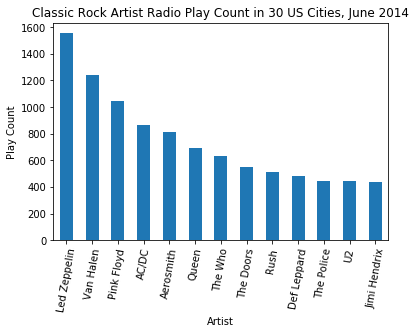

In [22]:
ax = merged_artists.sort_values(by="PlayCount",ascending=False).head(13).plot(kind="bar",rot=80,legend=False)
ax.set_title("Classic Rock Artist Radio Play Count in 30 US Cities, June 2014")
ax.set_xlabel("Artist")
ax.set_ylabel("Play Count")
plt.show()

The bar chart above is a direct result of combining the data from an external CSV and a SQL query.